In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler ,  StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pickle

# Preparation de données

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Fusion de données

In [58]:
df_feat = pd.read_csv('../encoded data/opamps-features.csv')
df_ref = pd.read_csv('../encoded data/opamps-xref.csv')

In [59]:
categorical_columns1 = ["Supplier_Package"]
numerical_columns = ["Maximum Input Offset Voltage","Maximum Single Supply Voltage","Minimum Single Supply Voltage","Number of Channels per Chip","Typical Gain Bandwidth Product"]

## Scaling

In [60]:
import helper_functions.preprocess as pp

df_feat_scaled , scaler = pp.scale(df_feat,numerical_columns)
df = pp.merge_datasets(df_feat_scaled,df_ref)

## Conversion des classes en données numériques

### Par une seule valeur
Pour ne pa ajouter des biais
La colonne "Closeness" est la valeur convertie des "Cross Reference Type".

In [61]:
base_means = {'A': 0.95, 'B': 0.8, 'C': 0.5, 'D': 0.3}
base_std = {'A': 0.025 / 3, 'B': 0.025 / 2.5, 'C': 0.025 / 2, 'D': 0.025 / 1.5}

In [62]:
df["Closeness"] = df["Cross Reference Type"].map(base_means)

<Axes: xlabel='Closeness', ylabel='Count'>

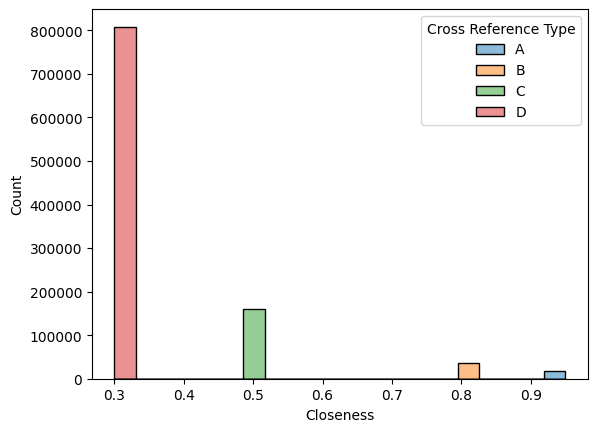

In [63]:
# df = pp.generate_closeness(df,base_means,base_std,n_std=3)
spread=0.2
sns.histplot(data=df, x='Closeness', hue='Cross Reference Type')

### Label Encoding des supplier_package

In [64]:
# prompt: label encoder for "Supplier_Package" column of df, apply it to "Supplier_Package_comp" too

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder on the "Supplier_Package" column
le.fit(df["Supplier_Package"])

# Transform the "Supplier_Package" column
df["Supplier_Package"] = le.transform(df["Supplier_Package"])

# Apply the same encoder to the "Supplier_Package_comp" column
df["Supplier_Package_comp"] = le.transform(df["Supplier_Package_comp"])


In [65]:

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_num =dict(zip(le.classes_, le.transform(le.classes_)))
num_label = dict(zip(le.transform(le.classes_),le.classes_))

print(num_label)

{0: 'Bare Die', 1: 'CAN', 2: 'CDIP', 3: 'CDIP N', 4: 'CFLAT', 5: 'CFP', 6: 'CFPAK', 7: 'CLLCC', 8: 'CPAK', 9: 'CSOIC', 10: 'Case P-5', 11: 'Chip', 12: 'DDPAK', 13: 'DFN', 14: 'DFN EP', 15: 'DFN-U1 EP', 16: 'DFN-W1 EP', 17: 'DIP', 18: 'DMP', 19: 'DSBGA', 20: 'Die', 21: 'EMP', 22: 'EQFN-E2 EP', 23: 'ESON', 24: 'ESON-U1', 25: 'ESON-W2 EP', 26: 'ESV', 27: 'FLP', 28: 'FPACK', 29: 'Flip-Chip', 30: 'HMSOP EP', 31: 'HSOIC EP', 32: 'HSOP EP', 33: 'HTSSOP EP', 34: 'HVSOF EP', 35: 'HVSSOP EP', 36: 'LCC', 37: 'LCCC', 38: 'LFCSP', 39: 'LFCSP EP', 40: 'MFP', 41: 'MMPAK', 42: 'MPAK', 43: 'MSOP', 44: 'MSOP EP', 45: 'Metal Can', 46: 'Micro', 47: 'Mini-DIP', 48: 'Mini-PDIP', 49: 'Mini-SO', 50: 'Not Mentioned', 51: 'PCSP-C3', 52: 'PCSP-CC EP', 53: 'PCSP-E3 EP', 54: 'PDIP', 55: 'PDIP N', 56: 'PFM', 57: 'PLCC', 58: 'PSOP', 59: 'QFN', 60: 'QFN EP', 61: 'QSOP', 62: 'SBCDIP', 63: 'SC-70', 64: 'SC-74A', 65: 'SC-88A', 66: 'SIP', 67: 'SMV', 68: 'SNT-A', 69: 'SO', 70: 'SO EP', 71: 'SO N', 72: 'SO W', 73: 'SOIC', 

In [66]:
unique_labels = len(num_label)

## Division des données (train,validation,test) et equiilibre des classes das les données d'entrainement

In [67]:
df_train, df_validation, df_test = pp.split_dataframe(df)

In [68]:
df_train = pp.balance_training_data(df_train,ratios={"A": 4, "B": 3, "C": 1, "D": 1/3})
print(f"Length : {len(df_train)}")

Length : 490523


### Preparation des vecteurs

In [69]:
columns_to_drop = ['Closeness', 'MPN', "MANUFACTURER",'MPN_comp',"MANUFACTURER_comp", "Cross Reference Type"]

In [70]:
X_train = df_train.drop(columns=columns_to_drop)
X_validation = df_validation.drop(columns=columns_to_drop)
X_test = df_test.drop(columns=columns_to_drop)

y_train = df_train['Closeness']
y_validation = df_validation['Closeness']
y_test = df_test['Closeness']

In [71]:
categorical_columns =categorical_columns1.copy()
categorical_columns += [i +"_comp" for i in categorical_columns1]

# Modele de Deep Learning avec embedding

## Preparation des tensors

In [72]:

X_train = torch.tensor(X_train.values, dtype=torch.float16)
X_validation = torch.tensor(X_validation.values, dtype=torch.float16)
X_test = torch.tensor(X_test.values, dtype=torch.float16)
y_train = torch.tensor(y_train.values, dtype=torch.float16).reshape(-1, 1)
y_validation = torch.tensor(y_validation.values, dtype=torch.float16).reshape(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float16).reshape(-1, 1)

In [73]:
batch_size = 4096*2

## Datasets

In [74]:
train_dataset = TensorDataset(X_train.cpu(), y_train.cpu())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True)

val_dataset = TensorDataset(X_validation.cpu(), y_validation.cpu())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)

test_dataset = TensorDataset(X_test.cpu(), y_test.cpu())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)

## Le Modele

In [75]:
class SimilarityModel(nn.Module):
    """
    A lightweight MLP for predicting closeness [0,1] based on numeric features and embeddings of two categorical inputs.
    """
    def __init__(self,
                 num_total_numeric: int = 10,
                 num_categories: int = unique_labels,
                 embed_dim: int = 8,
                 dropout: float = 0.1):
        super(SimilarityModel, self).__init__()

        # Embedding for the two categorical supplier_package fields
        self.embedding = nn.Embedding(num_categories, embed_dim)

        # Total input dimension = numeric features + 2 embeddings
        input_dim = num_total_numeric + 2 * embed_dim

        # Simplified MLP: just one hidden layer
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(16, 1)  # Output a single score
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Extract categorical indices
        sup1 = x[:, 4].long()   # Supplier_Package for component 1
        sup2 = x[:, 10].long()  # Supplier_Package for component 2

        # Get embeddings
        emb1 = self.embedding(sup1)
        emb2 = self.embedding(sup2)

        # Extract numeric features (excluding categorical indices)
        numeric = torch.cat((x[:, :4], x[:, 5:10], x[:, 11:]), dim=1)

        # Concatenate numeric features + embeddings
        features = torch.cat((numeric, emb1, emb2), dim=1)

        # Output score in [0,1]
        return torch.sigmoid(self.mlp(features))

## Entrainnement

In [ ]:
# model = SimilarityModel().to(device)
# model.load_state_dict(torch.load("similarity_model_weights_first_train_labelmap.pth"))

C:\Users\adamg\AppData\Local\Temp\ipykernel_70768\652958439.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("similarity_model_weights_fi

<All keys matched successfully>

In [29]:
model = SimilarityModel().to(device)

In [77]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

c:\Users\adamg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [31]:
num_epochs = 100

In [32]:
train_losses = []
val_losses = []

In [33]:
from tqdm import tqdm

for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_loader):
        xb, yb = xb.to(device).float(), yb.to(device).float()
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader):
            xb, yb = xb.to(device).float(), yb.to(device).float()
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f"Epoch {epoch:02d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


100%|██████████| 7/7 [00:00<00:00, 13.01it/s]


Epoch 01: Train Loss = 0.0280, Val Loss = 0.0118


100%|██████████| 7/7 [00:00<00:00, 10.07it/s]


Epoch 02: Train Loss = 0.0176, Val Loss = 0.0106


100%|██████████| 7/7 [00:00<00:00, 10.11it/s]


Epoch 03: Train Loss = 0.0159, Val Loss = 0.0102


100%|██████████| 7/7 [00:00<00:00, 10.93it/s]


Epoch 04: Train Loss = 0.0150, Val Loss = 0.0090


100%|██████████| 7/7 [00:00<00:00,  9.29it/s]


Epoch 05: Train Loss = 0.0146, Val Loss = 0.0088


100%|██████████| 7/7 [00:00<00:00,  8.34it/s]


Epoch 06: Train Loss = 0.0145, Val Loss = 0.0095


100%|██████████| 7/7 [00:00<00:00, 12.24it/s]


Epoch 07: Train Loss = 0.0141, Val Loss = 0.0091


100%|██████████| 7/7 [00:00<00:00, 10.49it/s]


Epoch 08: Train Loss = 0.0140, Val Loss = 0.0087


100%|██████████| 7/7 [00:00<00:00, 10.30it/s]


Epoch 09: Train Loss = 0.0137, Val Loss = 0.0079


100%|██████████| 7/7 [00:00<00:00, 13.32it/s]


Epoch 10: Train Loss = 0.0137, Val Loss = 0.0088


100%|██████████| 7/7 [00:00<00:00, 10.70it/s]


Epoch 11: Train Loss = 0.0136, Val Loss = 0.0084


100%|██████████| 7/7 [00:00<00:00, 10.42it/s]


Epoch 12: Train Loss = 0.0134, Val Loss = 0.0085


100%|██████████| 7/7 [00:00<00:00,  8.45it/s]


Epoch 13: Train Loss = 0.0133, Val Loss = 0.0086


100%|██████████| 7/7 [00:00<00:00, 10.90it/s]


Epoch 14: Train Loss = 0.0133, Val Loss = 0.0082


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]


Epoch 15: Train Loss = 0.0131, Val Loss = 0.0081


100%|██████████| 7/7 [00:00<00:00,  9.83it/s]


Epoch 16: Train Loss = 0.0127, Val Loss = 0.0082


100%|██████████| 7/7 [00:00<00:00, 12.62it/s]


Epoch 17: Train Loss = 0.0127, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 12.75it/s]


Epoch 18: Train Loss = 0.0127, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00, 12.61it/s]


Epoch 19: Train Loss = 0.0126, Val Loss = 0.0080


100%|██████████| 7/7 [00:00<00:00, 10.15it/s]


Epoch 20: Train Loss = 0.0125, Val Loss = 0.0079


100%|██████████| 7/7 [00:00<00:00, 11.37it/s]


Epoch 21: Train Loss = 0.0125, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00,  9.38it/s]


Epoch 22: Train Loss = 0.0124, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00,  8.15it/s]


Epoch 23: Train Loss = 0.0124, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00, 11.13it/s]


Epoch 24: Train Loss = 0.0124, Val Loss = 0.0079


100%|██████████| 7/7 [00:00<00:00, 10.88it/s]


Epoch 25: Train Loss = 0.0124, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  9.93it/s]


Epoch 26: Train Loss = 0.0124, Val Loss = 0.0081


100%|██████████| 7/7 [00:00<00:00, 10.62it/s]


Epoch 27: Train Loss = 0.0124, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 13.31it/s]


Epoch 28: Train Loss = 0.0123, Val Loss = 0.0078


 75%|███████▌  | 45/60 [00:04<00:01,  9.60it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000261D8A9D790>>
Traceback (most recent call last):
  File "C:\Users\adamg\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
100%|██████████| 7/7 [00:00<00:00, 12.80it/s]


Epoch 29: Train Loss = 0.0124, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 10.46it/s]


Epoch 30: Train Loss = 0.0123, Val Loss = 0.0079


100%|██████████| 7/7 [00:00<00:00, 10.75it/s]


Epoch 31: Train Loss = 0.0122, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00, 10.51it/s]


Epoch 32: Train Loss = 0.0121, Val Loss = 0.0074


 80%|████████  | 48/60 [00:05<00:01,  9.89it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000261D8A9D790>>
Traceback (most recent call last):
  File "C:\Users\adamg\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
100%|██████████| 7/7 [00:00<00:00, 10.52it/s]


Epoch 33: Train Loss = 0.0120, Val Loss = 0.0075


100%|██████████| 7/7 [00:00<00:00, 12.32it/s]


Epoch 34: Train Loss = 0.0121, Val Loss = 0.0080


100%|██████████| 7/7 [00:00<00:00, 12.84it/s]


Epoch 35: Train Loss = 0.0121, Val Loss = 0.0079


100%|██████████| 7/7 [00:00<00:00, 10.45it/s]


Epoch 36: Train Loss = 0.0120, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00,  8.80it/s]


Epoch 37: Train Loss = 0.0119, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00, 12.19it/s]


Epoch 38: Train Loss = 0.0119, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00, 10.67it/s]


Epoch 39: Train Loss = 0.0119, Val Loss = 0.0072


100%|██████████| 7/7 [00:00<00:00, 10.01it/s]


Epoch 40: Train Loss = 0.0119, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.49it/s]


Epoch 41: Train Loss = 0.0118, Val Loss = 0.0075


100%|██████████| 7/7 [00:00<00:00, 12.39it/s]


Epoch 42: Train Loss = 0.0118, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 11.77it/s]


Epoch 43: Train Loss = 0.0118, Val Loss = 0.0075


100%|██████████| 7/7 [00:01<00:00,  5.72it/s]


Epoch 44: Train Loss = 0.0119, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00,  9.37it/s]


Epoch 45: Train Loss = 0.0118, Val Loss = 0.0075


100%|██████████| 7/7 [00:00<00:00, 12.87it/s]


Epoch 46: Train Loss = 0.0118, Val Loss = 0.0072


100%|██████████| 7/7 [00:00<00:00, 12.55it/s]


Epoch 47: Train Loss = 0.0118, Val Loss = 0.0075


100%|██████████| 7/7 [00:00<00:00,  9.81it/s]


Epoch 48: Train Loss = 0.0117, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00, 12.91it/s]


Epoch 49: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  9.94it/s]


Epoch 50: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.08it/s]


Epoch 51: Train Loss = 0.0117, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00, 12.00it/s]


Epoch 52: Train Loss = 0.0117, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00,  8.48it/s]


Epoch 53: Train Loss = 0.0117, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00, 12.50it/s]


Epoch 54: Train Loss = 0.0117, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00,  9.64it/s]


Epoch 55: Train Loss = 0.0117, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00, 12.29it/s]


Epoch 56: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 11.75it/s]


Epoch 57: Train Loss = 0.0117, Val Loss = 0.0075


100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 58: Train Loss = 0.0117, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00,  9.25it/s]


Epoch 59: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  9.31it/s]


Epoch 60: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Epoch 61: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


Epoch 62: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.19it/s]


Epoch 63: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 11.26it/s]


Epoch 64: Train Loss = 0.0117, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00,  8.40it/s]


Epoch 65: Train Loss = 0.0117, Val Loss = 0.0072


100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 66: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.67it/s]


Epoch 67: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 68: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.58it/s]


Epoch 69: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  8.45it/s]


Epoch 70: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  8.82it/s]


Epoch 71: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  9.11it/s]


Epoch 72: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch 73: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 74: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


Epoch 75: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch 76: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  9.56it/s]


Epoch 77: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.17it/s]


Epoch 78: Train Loss = 0.0116, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00,  9.61it/s]


Epoch 79: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  9.13it/s]


Epoch 80: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 11.57it/s]


Epoch 81: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  9.83it/s]


Epoch 82: Train Loss = 0.0117, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


Epoch 83: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  8.11it/s]


Epoch 84: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 11.06it/s]


Epoch 85: Train Loss = 0.0117, Val Loss = 0.0074


100%|██████████| 7/7 [00:00<00:00, 12.64it/s]


Epoch 86: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.07it/s]


Epoch 87: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 13.02it/s]


Epoch 88: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.29it/s]


Epoch 89: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.43it/s]


Epoch 90: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00,  9.58it/s]


Epoch 91: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 13.28it/s]


Epoch 92: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.21it/s]


Epoch 93: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.29it/s]


Epoch 94: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.74it/s]


Epoch 95: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.14it/s]


Epoch 96: Train Loss = 0.0117, Val Loss = 0.0072


100%|██████████| 7/7 [00:00<00:00,  9.79it/s]


Epoch 97: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.45it/s]


Epoch 98: Train Loss = 0.0117, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 12.78it/s]


Epoch 99: Train Loss = 0.0116, Val Loss = 0.0073


100%|██████████| 7/7 [00:00<00:00, 10.11it/s]

Epoch 100: Train Loss = 0.0117, Val Loss = 0.0072


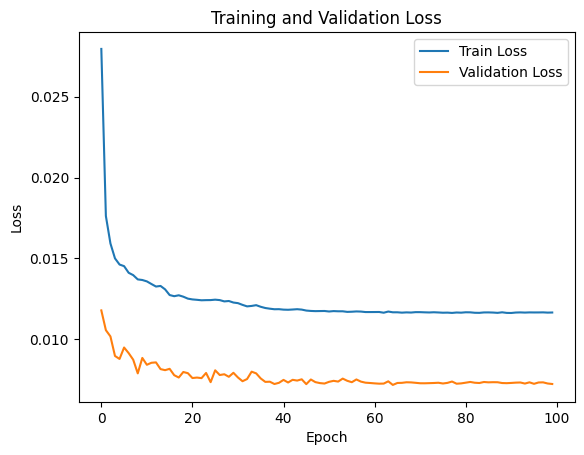

In [34]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Test

In [78]:
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float()
        preds = model(xb).cpu()
        
        all_preds.append(preds.flatten())
        all_targets.append(yb.flatten())
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_targets).numpy()

mse_test = ((y_pred - y_true) ** 2).mean()
print(f"Test MSE: {mse_test:.6f}")

Test MSE: 0.014980


## Visualisation des resultats

In [23]:
df_test_results = pd.DataFrame({
    'y_test': y_true.flatten(),
    'Cross Reference Type': df_test['Cross Reference Type'].values,
    'y_pred': y_pred.flatten()
})

C:\Users\adamg\AppData\Local\Temp\ipykernel_70768\2580040288.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


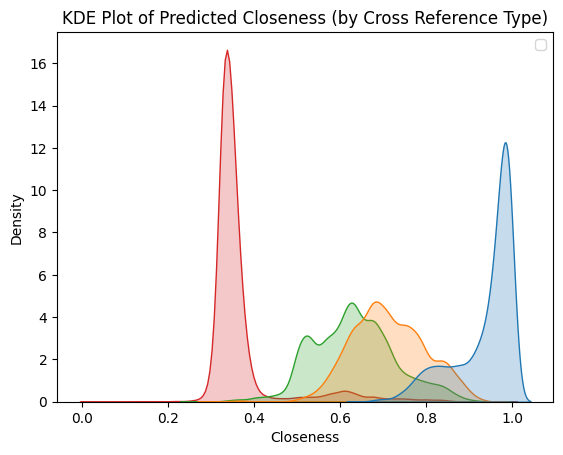

In [24]:
sns.kdeplot(
    data=df_test_results.sort_values("Cross Reference Type"),
    x='y_pred',
    hue='Cross Reference Type',
    fill=True,
    common_norm=False
)
plt.xlabel("Closeness")
plt.ylabel("Density")
plt.title("KDE Plot of Predicted Closeness (by Cross Reference Type)")
plt.legend()
plt.show()

## Creation de la matrice de similarités

In [79]:
n = len(df_feat_scaled)

In [80]:
df_f = df_feat_scaled.drop(columns=["MPN","MANUFACTURER"])

In [81]:
matrix = np.zeros((n, n), dtype=np.float32) 

In [83]:
from tqdm import tqdm
for i in tqdm(range(n), desc="Building closeness matrix"):
    # Get current product features
    product_i = df_f.iloc[i:i+1]
    merged_df = product_i.merge(df_f, how='cross',suffixes = ("","_comp"))

    merged_df['Supplier_Package'] = le.transform(merged_df['Supplier_Package'])
    merged_df['Supplier_Package_comp'] = le.transform(merged_df['Supplier_Package_comp'])
    X_tensor = torch.tensor(merged_df.values, dtype=torch.long)
    model.eval()
    with torch.no_grad():
        y = model(X_tensor.to(device)).cpu().numpy()
    y = y.flatten()
    
    matrix[i, :] = y

Building closeness matrix: 100%|██████████| 18352/18352 [04:52<00:00, 62.67it/s]


In [84]:
np.save("closeness_map MLP with embedding.npy", matrix)

## Visualisation de la matrice

In [53]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.export_matrix_downscaled(matrix , name="MLP with embedding on closeness map")

Downscaling from (18352, 18352) to (10000, 10000) ...
Saved MLP with embedding on closeness map at ~(10000x10000) px, dpi=500.


# Extraction des embeddings

## Distance Supplier Package

In [85]:
# Compute Euclidean distance between embeddings for each row in df
with torch.no_grad():
    emb1 = model.embedding(torch.tensor(df['Supplier_Package'].values, dtype=torch.long, device=device))
    emb2 = model.embedding(torch.tensor(df['Supplier_Package_comp'].values, dtype=torch.long, device=device))
    dist = torch.norm(emb1 - emb2, dim=1).cpu().numpy()
df['distance_Supplier_Package'] = dist

### Visualisation des distances 

Text(0.5, 1.0, 'Distance entre Supplier_Package et Supplier_Package_comp')

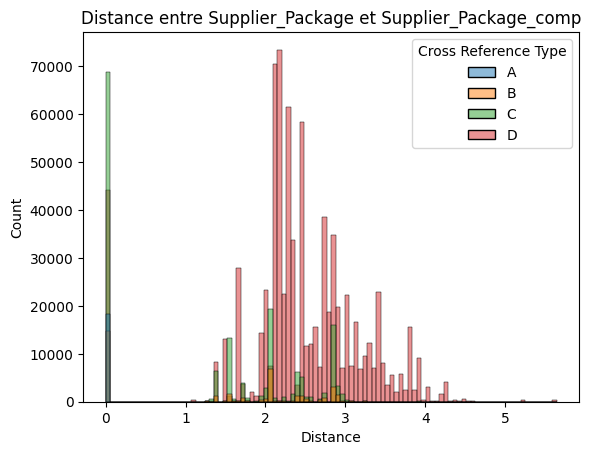

In [29]:
sns.histplot(data=df, x='distance_Supplier_Package', hue='Cross Reference Type', fill=True, common_norm=False,bins=100)
plt.xlabel("Distance")
plt.title("Distance entre Supplier_Package et Supplier_Package_comp")

## Cosine Similarity Supplier Package

In [86]:
# Compute cosine similarity between embeddings for each row in df
with torch.no_grad():
    emb1 = model.embedding(torch.tensor(df['Supplier_Package'].values, dtype=torch.long, device=device))
    emb2 = model.embedding(torch.tensor(df['Supplier_Package_comp'].values, dtype=torch.long, device=device))
    cos_sim = F.cosine_similarity(emb1, emb2, dim=1).cpu().numpy()
df['cosine_similarity_Supplier_Package'] = cos_sim

### Visualisation de la similarité Cosinus 

Text(0.5, 1.0, 'Similarité cosinus entre Supplier_Package et Supplier_Package_comp')

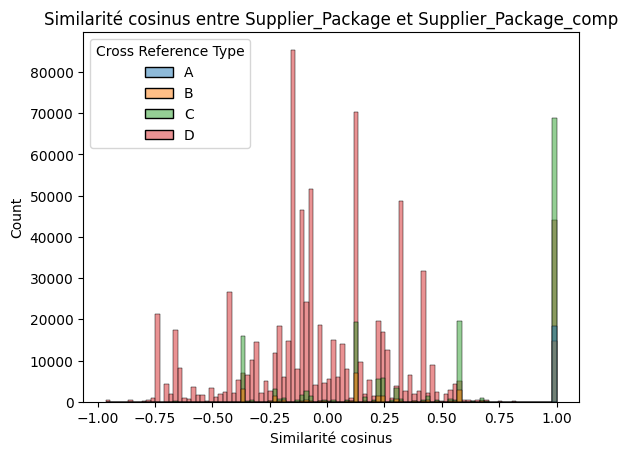

In [31]:
sns.histplot(data=df, x='cosine_similarity_Supplier_Package', hue='Cross Reference Type', fill=True, common_norm=False,bins=100)
plt.xlabel("Similarité cosinus")
plt.title("Similarité cosinus entre Supplier_Package et Supplier_Package_comp")

# Recalcul des distance (pour creer une colonne "Closeness" plus precise)

In [87]:
for col in numerical_columns:
    df["distance_"+col] = np.abs(df[col] - df[col+"_comp"])

In [43]:
df.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp', 'Closeness',
       'distance_Supplier_Package', 'cosine_similarity_Supplier_Package',
       'distance_Maximum Input Offset Voltage',
       'distance_Maximum Single Supply Voltage',
       'distance_Minimum Single Supply Voltage',
       'distance_Number of Channels per Chip',
       'distance_Typical Gain Bandwidth Product', 'distance_cosine',
       'distance'],
      dtype='object')

## Distance en valeur absolue en utilisant les nouvelles distances de supplier_package (par embedding)

In [88]:
df["distance_cosine"] = 1 - (df["cosine_similarity_Supplier_Package"]+1)/2

In [89]:
df['distance_Supplier_Package'] = df['distance_Supplier_Package']/df['distance_Supplier_Package'].max()

In [90]:
df["distance"] = (df['distance_Maximum Input Offset Voltage']+df['distance_Maximum Single Supply Voltage']+df['distance_Minimum Single Supply Voltage']+df['distance_Number of Channels per Chip']+df['distance_Typical Gain Bandwidth Product'] + 2*df["distance_Supplier_Package"] + 3* df["distance_cosine"])/5

### Visualisation des distances

<Axes: xlabel='distance', ylabel='Count'>

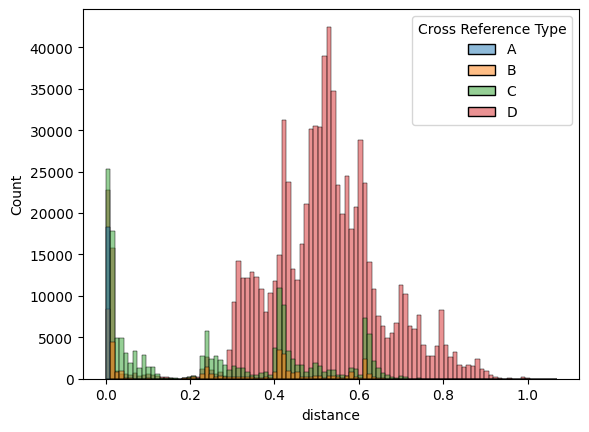

In [91]:
sns.histplot(data=df, x='distance', hue='Cross Reference Type', bins=100)

## Calcul de Closenss (formulation en valeur absolue)

In [92]:
df["Closeness"] = df["Cross Reference Type"].map(base_means)

In [93]:
spread = 0.1

In [94]:
df["Closeness"] -= (df["distance"]*spread)

<Axes: xlabel='Closeness', ylabel='Count'>

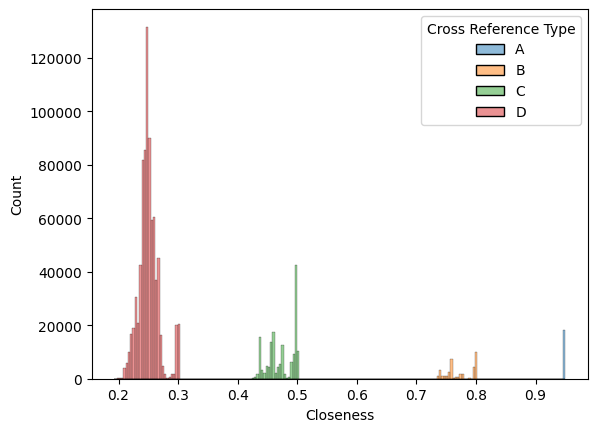

In [95]:
sns.histplot(data=df, x='Closeness', hue='Cross Reference Type', bins=200)

In [9]:
df.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp'],
      dtype='object')

# Entrainement du même modele avec la nouvelle colonne "Closeness"

## Données

In [96]:
columns_to_drop = ['Closeness',
 'MPN',
 'MANUFACTURER',
 'MPN_comp',
 'MANUFACTURER_comp',
 'Cross Reference Type','distance_Supplier_Package', 'cosine_similarity_Supplier_Package',
       'distance_Maximum Input Offset Voltage',
       'distance_Maximum Single Supply Voltage',
       'distance_Minimum Single Supply Voltage',
       'distance_Number of Channels per Chip',
       'distance_Typical Gain Bandwidth Product', 'distance_cosine',
       'distance'] 

In [97]:
df_train, df_validation, df_test = pp.split_dataframe(df)
df_train = pp.balance_training_data(df_train,ratios={"A": 4, "B": 3, "C": 1, "D": 1/3})
print(f"Length : {len(df_train)}")

Length : 490523


In [98]:
X_train = df_train.drop(columns=columns_to_drop)
X_validation = df_validation.drop(columns=columns_to_drop)
X_test = df_test.drop(columns=columns_to_drop)

y_train = df_train['Closeness']
y_validation = df_validation['Closeness']
y_test = df_test['Closeness']

In [99]:
df_train.drop(columns=columns_to_drop).columns

Index(['Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product',
       'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp'],
      dtype='object')

In [100]:

X_train = torch.tensor(X_train.values, dtype=torch.float16)
X_validation = torch.tensor(X_validation.values, dtype=torch.float16)
X_test = torch.tensor(X_test.values, dtype=torch.float16)
y_train = torch.tensor(y_train.values, dtype=torch.float16).reshape(-1, 1)
y_validation = torch.tensor(y_validation.values, dtype=torch.float16).reshape(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float16).reshape(-1, 1)

In [101]:
train_dataset = TensorDataset(X_train.cpu(), y_train.cpu())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True)

val_dataset = TensorDataset(X_validation.cpu(), y_validation.cpu())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)

test_dataset = TensorDataset(X_test.cpu(), y_test.cpu())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)

In [ ]:
# torch.save(model.state_dict(), "similarity_model_weights_first_train_labelmap.pth")

## Entrainement

In [ ]:
model = SimilarityModel().to(device)
# model.load_state_dict(torch.load("similarity_model_weights_second_train_closeness_abs_embedding.pth"))

C:\Users\adamg\AppData\Local\Temp\ipykernel_70768\3997953558.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("similarity_model_weights_s

<All keys matched successfully>

In [50]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

c:\Users\adamg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [131]:
train_losses = []
val_losses = []

In [132]:
from tqdm import tqdm

for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_loader):
        xb, yb = xb.to(device).float(), yb.to(device).float()
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader):
            xb, yb = xb.to(device).float(), yb.to(device).float()
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f"Epoch {epoch:02d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


100%|██████████| 7/7 [00:00<00:00, 16.78it/s]


Epoch 01: Train Loss = 0.0298, Val Loss = 0.0110


100%|██████████| 7/7 [00:00<00:00, 17.30it/s]


Epoch 02: Train Loss = 0.0178, Val Loss = 0.0106


100%|██████████| 7/7 [00:00<00:00, 16.89it/s]


Epoch 03: Train Loss = 0.0162, Val Loss = 0.0098


100%|██████████| 7/7 [00:00<00:00, 17.10it/s]


Epoch 04: Train Loss = 0.0155, Val Loss = 0.0090


100%|██████████| 7/7 [00:00<00:00, 17.18it/s]


Epoch 05: Train Loss = 0.0150, Val Loss = 0.0096


100%|██████████| 7/7 [00:00<00:00, 17.44it/s]


Epoch 06: Train Loss = 0.0145, Val Loss = 0.0090


100%|██████████| 7/7 [00:00<00:00, 15.90it/s]


Epoch 07: Train Loss = 0.0143, Val Loss = 0.0094


100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


Epoch 08: Train Loss = 0.0141, Val Loss = 0.0095


100%|██████████| 7/7 [00:00<00:00, 13.27it/s]


Epoch 09: Train Loss = 0.0139, Val Loss = 0.0094


100%|██████████| 7/7 [00:00<00:00, 17.59it/s]


Epoch 10: Train Loss = 0.0137, Val Loss = 0.0095


100%|██████████| 7/7 [00:00<00:00, 17.49it/s]


Epoch 11: Train Loss = 0.0134, Val Loss = 0.0085


100%|██████████| 7/7 [00:00<00:00, 17.23it/s]


Epoch 12: Train Loss = 0.0133, Val Loss = 0.0084


100%|██████████| 7/7 [00:00<00:00, 17.54it/s]


Epoch 13: Train Loss = 0.0132, Val Loss = 0.0085


100%|██████████| 7/7 [00:00<00:00, 15.84it/s]


Epoch 14: Train Loss = 0.0132, Val Loss = 0.0082


100%|██████████| 7/7 [00:00<00:00, 17.00it/s]


Epoch 15: Train Loss = 0.0131, Val Loss = 0.0079


100%|██████████| 7/7 [00:00<00:00, 17.21it/s]


Epoch 16: Train Loss = 0.0131, Val Loss = 0.0081


100%|██████████| 7/7 [00:00<00:00, 17.11it/s]


Epoch 17: Train Loss = 0.0130, Val Loss = 0.0083


100%|██████████| 7/7 [00:00<00:00, 16.70it/s]


Epoch 18: Train Loss = 0.0129, Val Loss = 0.0079


100%|██████████| 7/7 [00:00<00:00, 17.38it/s]


Epoch 19: Train Loss = 0.0129, Val Loss = 0.0080


100%|██████████| 7/7 [00:00<00:00, 17.06it/s]


Epoch 20: Train Loss = 0.0128, Val Loss = 0.0083


100%|██████████| 7/7 [00:00<00:00, 17.64it/s]


Epoch 21: Train Loss = 0.0128, Val Loss = 0.0079


100%|██████████| 7/7 [00:00<00:00, 17.43it/s]


Epoch 22: Train Loss = 0.0126, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.64it/s]


Epoch 23: Train Loss = 0.0126, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.03it/s]


Epoch 24: Train Loss = 0.0126, Val Loss = 0.0081


100%|██████████| 7/7 [00:00<00:00, 17.08it/s]


Epoch 25: Train Loss = 0.0126, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.21it/s]


Epoch 26: Train Loss = 0.0125, Val Loss = 0.0083


100%|██████████| 7/7 [00:00<00:00, 17.53it/s]


Epoch 27: Train Loss = 0.0125, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.53it/s]


Epoch 28: Train Loss = 0.0125, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.50it/s]


Epoch 29: Train Loss = 0.0125, Val Loss = 0.0080


100%|██████████| 7/7 [00:00<00:00, 17.32it/s]


Epoch 30: Train Loss = 0.0125, Val Loss = 0.0080


100%|██████████| 7/7 [00:00<00:00, 17.25it/s]


Epoch 31: Train Loss = 0.0124, Val Loss = 0.0082


100%|██████████| 7/7 [00:00<00:00, 17.26it/s]


Epoch 32: Train Loss = 0.0125, Val Loss = 0.0081


100%|██████████| 7/7 [00:00<00:00, 17.31it/s]


Epoch 33: Train Loss = 0.0124, Val Loss = 0.0079


100%|██████████| 7/7 [00:00<00:00, 17.49it/s]


Epoch 34: Train Loss = 0.0123, Val Loss = 0.0079


100%|██████████| 7/7 [00:00<00:00, 16.34it/s]


Epoch 35: Train Loss = 0.0122, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00, 16.76it/s]


Epoch 36: Train Loss = 0.0123, Val Loss = 0.0080


100%|██████████| 7/7 [00:00<00:00, 17.57it/s]


Epoch 37: Train Loss = 0.0123, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.10it/s]


Epoch 38: Train Loss = 0.0122, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00, 17.42it/s]


Epoch 39: Train Loss = 0.0123, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.29it/s]


Epoch 40: Train Loss = 0.0122, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.60it/s]


Epoch 41: Train Loss = 0.0123, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.12it/s]


Epoch 42: Train Loss = 0.0122, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 18.26it/s]


Epoch 43: Train Loss = 0.0122, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.64it/s]


Epoch 44: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.50it/s]


Epoch 45: Train Loss = 0.0121, Val Loss = 0.0076


100%|██████████| 7/7 [00:00<00:00, 17.31it/s]


Epoch 46: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.28it/s]


Epoch 47: Train Loss = 0.0121, Val Loss = 0.0080


100%|██████████| 7/7 [00:00<00:00, 17.30it/s]


Epoch 48: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.03it/s]


Epoch 49: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.24it/s]


Epoch 50: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.33it/s]


Epoch 51: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.19it/s]


Epoch 52: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.62it/s]


Epoch 53: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.28it/s]


Epoch 54: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 16.99it/s]


Epoch 55: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.36it/s]


Epoch 56: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.29it/s]


Epoch 57: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.28it/s]


Epoch 58: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 16.83it/s]


Epoch 59: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.59it/s]


Epoch 60: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 16.90it/s]


Epoch 61: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.57it/s]


Epoch 62: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 16.54it/s]


Epoch 63: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.37it/s]


Epoch 64: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.03it/s]


Epoch 65: Train Loss = 0.0120, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.08it/s]


Epoch 66: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.27it/s]


Epoch 67: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.06it/s]


Epoch 68: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.08it/s]


Epoch 69: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 16.91it/s]


Epoch 70: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.18it/s]


Epoch 71: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.32it/s]


Epoch 72: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.03it/s]


Epoch 73: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.28it/s]


Epoch 74: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.40it/s]


Epoch 75: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 16.83it/s]


Epoch 76: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.11it/s]


Epoch 77: Train Loss = 0.0120, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.30it/s]


Epoch 78: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.51it/s]


Epoch 79: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 16.33it/s]


Epoch 80: Train Loss = 0.0120, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.69it/s]


Epoch 81: Train Loss = 0.0120, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.38it/s]


Epoch 82: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.48it/s]


Epoch 83: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 16.58it/s]


Epoch 84: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.68it/s]


Epoch 85: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.08it/s]


Epoch 86: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.30it/s]


Epoch 87: Train Loss = 0.0120, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 16.82it/s]


Epoch 88: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.73it/s]


Epoch 89: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.13it/s]


Epoch 90: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.72it/s]


Epoch 91: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 16.99it/s]


Epoch 92: Train Loss = 0.0120, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 16.78it/s]


Epoch 93: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.79it/s]


Epoch 94: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 16.26it/s]


Epoch 95: Train Loss = 0.0120, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.22it/s]


Epoch 96: Train Loss = 0.0121, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.08it/s]


Epoch 97: Train Loss = 0.0121, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 17.56it/s]


Epoch 98: Train Loss = 0.0120, Val Loss = 0.0077


100%|██████████| 7/7 [00:00<00:00, 17.59it/s]


Epoch 99: Train Loss = 0.0120, Val Loss = 0.0078


100%|██████████| 7/7 [00:00<00:00, 16.64it/s]

Epoch 100: Train Loss = 0.0120, Val Loss = 0.0077


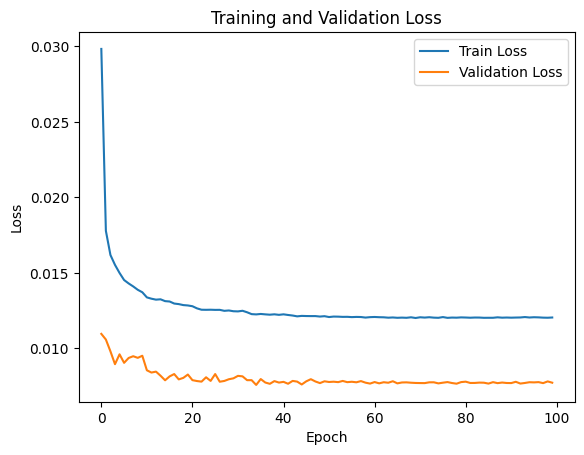

In [133]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Test

In [103]:
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float()
        preds = model(xb).cpu()
        
        all_preds.append(preds.flatten())
        all_targets.append(yb.flatten())
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_targets).numpy()

mse_test = ((y_pred - y_true) ** 2).mean()
print(f"Test MSE: {mse_test:.6f}")

Test MSE: 0.016244


## Visualisation 

In [52]:
df_test_results = pd.DataFrame({
    'y_test': y_true.flatten(),
    'Cross Reference Type': df_test['Cross Reference Type'].values,
    'y_pred': y_pred.flatten()
})

C:\Users\adamg\AppData\Local\Temp\ipykernel_70768\2580040288.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


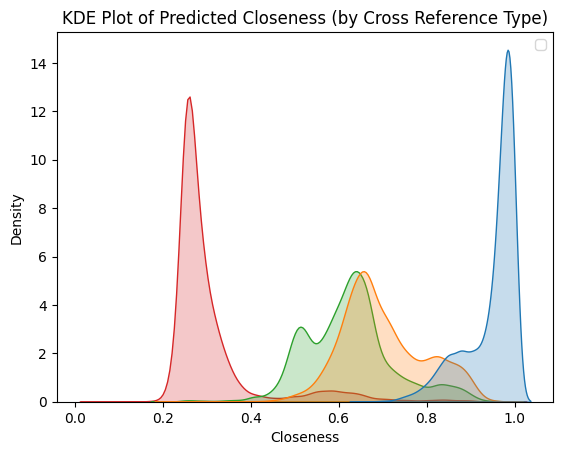

In [53]:
sns.kdeplot(
    data=df_test_results.sort_values("Cross Reference Type"),
    x='y_pred',
    hue='Cross Reference Type',
    fill=True,
    common_norm=False
)
plt.xlabel("Closeness")
plt.ylabel("Density")
plt.title("KDE Plot of Predicted Closeness (by Cross Reference Type)")
plt.legend()
plt.show()

## Creation de la matrice de similarités

In [104]:
n = len(df_feat_scaled)
df_f = df_feat_scaled.drop(columns=["MPN","MANUFACTURER"])
matrix = np.zeros((n, n), dtype=np.float32) 
for i in tqdm(range(n), desc="Building closeness matrix"):
    # Get current product features
    product_i = df_f.iloc[i:i+1]
    merged_df = product_i.merge(df_f, how='cross',suffixes = ("","_comp"))

    merged_df['Supplier_Package'] = le.transform(merged_df['Supplier_Package'])
    merged_df['Supplier_Package_comp'] = le.transform(merged_df['Supplier_Package_comp'])
    X_tensor = torch.tensor(merged_df.values, dtype=torch.long)
    model.eval()
    with torch.no_grad():
        y = model(X_tensor.to(device)).cpu().numpy()
    y = y.flatten()
    
    matrix[i, :] = y

Building closeness matrix: 100%|██████████| 18352/18352 [04:38<00:00, 65.84it/s]


In [105]:
np.save("closeness_map MLP with embedding_try_2.npy", matrix)

In [139]:
import helper_functions.visualize as vz
import importlib
importlib.reload(vz)
vz.export_matrix_downscaled(matrix , name="MLP with embedding on closeness map_try_3")

Downscaling from (18352, 18352) to (10000, 10000) ...
Saved MLP with embedding on closeness map_try_3 at ~(10000x10000) px, dpi=500.


In [140]:
torch.save(model.state_dict(), "similarity_model_weights_third_train_closeness_abs_embedding.pth")